In [1]:
import numpy as np

import matplotlib.pyplot as plt

import mlrfit as mf
import mfmodel as mfm

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1500
signal_to_noise = 4


nsamples = 20
L = 10

# ranks = np.array([5, 4, 3, 3, 2, 2, 2, 2, 1])
ranks = np.array([5, 5, 5, 4, 3, 3, 3, 3, 2, 1])
# ranks = np.array([10, 10, 10, 4, 3, 3, 3, 3, 2, 1])
rank = ranks.sum()

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
# for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, n+1]:
for ngroups in [2, 5, 9, 17, 33, 65, 129, 257, 513, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1500.0
level=1, num_groups=4, mean_size=375.0
level=2, num_groups=8, mean_size=187.5
level=3, num_groups=16, mean_size=93.8
level=4, num_groups=32, mean_size=46.9
level=5, num_groups=64, mean_size=23.4
level=6, num_groups=128, mean_size=11.7
level=7, num_groups=256, mean_size=5.9
level=8, num_groups=512, mean_size=2.9
level=9, num_groups=1500, mean_size=1.0


In [5]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=32.8048623455216, noise_var=8.074922524438765
SNR=4.062560630920933, signal_to_noise=4


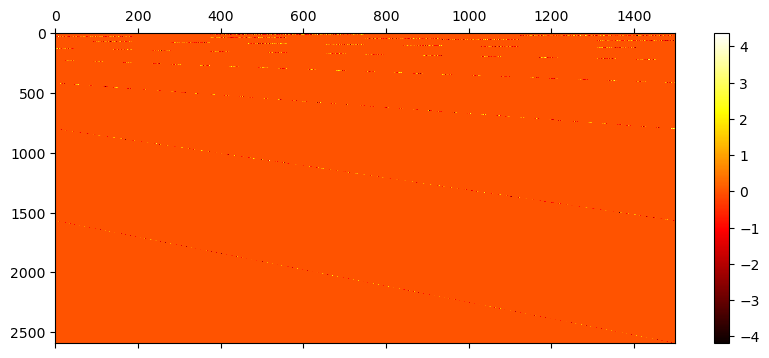

(1500, 2593)


In [6]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [7]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [8]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=10, num_sparsities=512
(512, 9) [  0   3   7  15  31  63 127 255 511]


In [10]:
for _ in range(5):
    true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=False)
    true_compressed_F = true_mlr.B[:, :-1]
    F_Lm1, D = true_compressed_F+0, true_D_noise+0
    pi = F_hpart['pi']
    F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

    ranks_F = ranks + 0
    true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
    true_mfm.inv_coefficients() 

    F_Lm1 = true_mfm.F 
    D = true_mfm.D 

    B_L = true_mfm.inv_B + 0
    B_L[:, :-1] /= 3
    C_L = true_mfm.inv_C 
    F_L = np.concatenate([F_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)

    reldiff = mfm.sp_loss_iter_refinement(F_Lm1, B_L, C_L, D, F_hpart, true_mfm.inv_hpart, ranks_F, true_mfm.inv_ranks)
    reldiff2 = mfm.loss_iter_refinement(F_L, B_L, C_L, F_hpart, true_mfm.inv_hpart, ranks_F, true_mfm.inv_ranks, 
                                        si_groups, row_selectors, debug=True)
    print(reldiff, reldiff2)
    assert np.allclose(reldiff, reldiff2)

print("PASSED")

signal_var=33.35739815607043, noise_var=8.409143814058654
SNR=3.9668007699312446, signal_to_noise=4
114.36906174240958 114.36906174240966
signal_var=33.12866699900297, noise_var=8.161161143192647
SNR=4.059308034449988, signal_to_noise=4
1112.0017548164515 1112.0017548164512
signal_var=32.77547432470262, noise_var=8.143127502141372
SNR=4.024924614785138, signal_to_noise=4
176.9354674667122 176.93546746671217
signal_var=33.21406159421827, noise_var=8.217243115837416
SNR=4.041995730928723, signal_to_noise=4
232.5227303609111 232.52273036091148
signal_var=32.820732686718664, noise_var=8.144352209418003
SNR=4.029876390753985, signal_to_noise=4
2028.6526452962153 2028.652645296216
PASSED


# $$ \Delta = \tilde \Sigma^{-1}(I - \Sigma \tilde \Sigma^{-1}) $$

In [11]:
true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.inv_coefficients(refine=True, printing=True, eps=-1e-16, max_iter=2) 

reldiff=0.0, ranks.sum()=34
t=0, reldiff=0.0, ranks.sum()=133
t=1, reldiff=0.0, ranks.sum()=430
terminated with reldiff=0.0


In [12]:
tilde_B = mf.convert_compressed_to_sparse(true_mfm.inv_B, hpart["rows"], true_mfm.inv_ranks)
tilde_C = mf.convert_compressed_to_sparse(true_mfm.inv_C, hpart["rows"], true_mfm.inv_ranks)
Sigma_inv = tilde_B @ tilde_C.T

np.allclose(Sigma_inv.toarray(), Sigma_inv.T.toarray())

True

In [13]:
mlr_inv = mf.MLRMatrix(B=true_mfm.inv_B, C=true_mfm.inv_C, hpart=hpart, ranks=true_mfm.inv_ranks)
mlr_inv.construct_sparse_format()
true_mlr.construct_sparse_format()
print(mlr_inv.ranks, true_mlr.ranks)

for _ in range(10):
    v = np.random.randn(n, 1)
    hat_x = mlr_inv.matvec(v)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(), v)) / np.linalg.norm(v)
    print(f"{reldiff=}")
    assert reldiff < 1e-9

[65 65 65 52 39 39 39 39 26  1] [5 5 5 4 3 3 3 3 2 1]
reldiff=5.249014783733304e-15
reldiff=1.413503765111829e-14
reldiff=1.2879682975523282e-14
reldiff=1.0707514322239081e-14
reldiff=1.0096713616439261e-14
reldiff=1.037349432909501e-14
reldiff=9.236202340904463e-15
reldiff=3.179852139365793e-14
reldiff=1.5382725439846852e-14
reldiff=1.8528799028679584e-14


In [14]:
true_mlr.construct_sparse_format()
print(true_mfm.inv_ranks, true_mlr.ranks)

for _ in range(10):
    v = np.random.randn(n, 1)
    hat_x = true_mfm.solve(v)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(), v)) / np.linalg.norm(v)
    print(f"{reldiff=}")
    assert reldiff < 1e-9

[65 65 65 52 39 39 39 39 26  1] [5 5 5 4 3 3 3 3 2 1]
reldiff=1.0490137131143265e-14
reldiff=5.5019569566002585e-15
reldiff=6.781341787644078e-15
reldiff=1.2290504630553983e-14
reldiff=3.5996862335275105e-15
reldiff=9.158327542517347e-15
reldiff=1.1532801912310344e-14
reldiff=1.870756365833556e-14
reldiff=1.5476518476883112e-14
reldiff=9.45918948641581e-15


In [15]:
for _ in range(5):
    true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=False)
    true_compressed_F = true_mlr.B[:, :-1]
    F_Lm1, D = true_compressed_F+0, true_D_noise+0
    pi = F_hpart['pi']
    F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]

    ranks_F = ranks + 0
    true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
    true_mfm.inv_coefficients() 

    F_Lm1 = true_mfm.F 
    D = true_mfm.D 

    B_L = true_mfm.inv_B 
    C_L = true_mfm.inv_C 
    F_L = np.concatenate([F_Lm1, np.sqrt(D).reshape(-1, 1)], axis=1)

    reldiff = mfm.sp_loss_iter_refinement(F_Lm1, B_L, C_L, D, F_hpart, hpart["rows"], ranks_F, true_mfm.inv_ranks)
    reldiff2 = mfm.loss_iter_refinement(F_L, B_L, C_L, F_hpart, hpart["rows"], ranks_F, true_mfm.inv_ranks, 
                                        si_groups, row_selectors, debug=True)
    print(reldiff, reldiff2)
    assert np.allclose(reldiff, reldiff2)

print("PASSED")

signal_var=32.743048047787255, noise_var=8.162841757589495
SNR=4.011231507378424, signal_to_noise=4
1.480400872141634e-11 0.0
signal_var=33.02413365903145, noise_var=8.419617718565032
SNR=3.922284213238579, signal_to_noise=4
1.3821839703308944e-10 5.6524115461564106e-09
signal_var=33.20497776656362, noise_var=8.282458356675411
SNR=4.00907270965044, signal_to_noise=4
3.0305882940232204e-12 0.0
signal_var=33.45913172433949, noise_var=8.341686008582172
SNR=4.0110754216732385, signal_to_noise=4
4.450208280414907e-13 6.926618503805472e-10
signal_var=32.8116515626674, noise_var=8.35273779125263
SNR=3.928251117499374, signal_to_noise=4
2.7031407863924708e-12 0.0
PASSED
